## Import Library

In [3]:
import json
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from nltk_utils import tokenize, stem, bag_of_words
# from model import create_model
import matplotlib.pyplot as plt
from keras import layers, models
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import pickle


## Define Variables

In [4]:
PATH_INTENTS = '../../data/intents.json'
PATH_MODEL = 'tf_model_tf-idf.pkl'
PATH_METADATA = 'tf_metadata_tf-idf.json'

In [5]:
# Define lists
all_words = []  # Words in the patterns
tags = []       # Tags of sentences
xy = []         # (Pattern sentence, Tag) pairs

## Load Data

In [6]:
# Open file json
with open(PATH_INTENTS, 'r') as f:
    intents = json.load(f)

## Data Preparation

In [7]:
# # Process each intent
# for intent in intents['intents']:
#     tag = intent['tag']
#     tags.append(tag)
#     for pattern in intent['patterns']:
#         w = tokenize(pattern)
#         all_words.extend(w)
#         xy.append((w, tag))

In [8]:
# Process each intent
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        xy.append((pattern, tag))
        all_words.append(pattern)

In [9]:
# Stemming
ignore_words = ['?', '!', '.', ',']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# all_words = sorted(set(all_words))
# tags = sorted(set(tags))

In [10]:
tags = sorted(set(tags))
tag_to_index = {tag: idx for idx, tag in enumerate(tags)}

In [11]:
# # Create training data
# x_train = []
# y_train = []
# for (pattern_sentence, tag) in xy:
#     bag = bag_of_words(pattern_sentence, all_words)
#     x_train.append(bag)
#     y_train.append(tag)

In [12]:
# Melakukan vektorisasi untuk mengekstrak fitur dengan TF-IDF
vectorizer = TfidfVectorizer(tokenizer=tokenize,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [13]:
# Create TF-IDF vectorizer and transform the corpus
# vectorizer = TfidfVectorizer(tokenizer=tokenize)
x_train = vectorizer.fit_transform(all_words).toarray()
y_train = np.array([tag_to_index[tag] for _, tag in xy])

d:\Coding\Projects\HearMePal\env\lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
# Convert to numpy arrays
x_train = np.array(x_train)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(tags))

In [15]:
# Mengubah ukuran data menjadi ukuran yang diterima oleh LTSM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [16]:
x_train.shape

(232, 50, 1)

## Modeling

In [17]:
# Define hyperparameters
input_size = len(x_train[0])
hidden_size = 8
output_size = len(tags)
learning_rate = 0.001
num_epochs = 1000
batch_size = 8

In [18]:
output_size

80

In [19]:
# Create the model
# model = models.Sequential()
# model.add(layers.Input(shape=(input_size,)))
# model.add(layers.Dense(64))
# model.add(layers.Dense(32))
# model.add(layers.Dense(16))
# model.add(layers.Dense(hidden_size))
# model.add(layers.Dense(output_size, activation='softmax'))

In [20]:
len(xy)

232

In [21]:
input_size

50

In [22]:
x_train.shape

(232, 50, 1)

In [23]:
y_train.shape

(232, 80)

In [28]:
model = models.Sequential()
model.add(layers.Input(shape=(input_size,)))
model.add(layers.Dense(64))
model.add(layers.Dense(32))
model.add(layers.Dense(16))
model.add(layers.Dense(hidden_size))
model.add(layers.Dense(output_size, activation='softmax'))

In [29]:
# model = Sequential()
# model.add(layers.Input(shape=(input_size,1)))
# model.add(LSTM(32, return_sequences=True))
# model.add(LayerNormalization())
# model.add(LSTM(32, return_sequences=True))
# model.add(LayerNormalization())
# model.add(LSTM(32))
# model.add(LayerNormalization())
# model.add(Dense(128, activation="relu"))
# model.add(LayerNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(128, activation="relu"))
# model.add(LayerNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(output_size, activation="softmax"))

In [30]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Train the model
# model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_split=0.3)

Epoch 1/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.0480 - loss: 4.3859 - val_accuracy: 0.0000e+00 - val_loss: 4.4079
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1208 - loss: 4.3057 - val_accuracy: 0.0000e+00 - val_loss: 4.4476
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1337 - loss: 4.2024 - val_accuracy: 0.0000e+00 - val_loss: 4.5554
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0924 - loss: 4.0470 - val_accuracy: 0.0000e+00 - val_loss: 4.8695
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0523 - loss: 3.8240 - val_accuracy: 0.0000e+00 - val_loss: 5.6049
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0933 - loss: 3.5858 - val_accuracy: 0.0000e+00 - val_loss: 6.0614
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1187 - loss: 3.3626 - val_accuracy: 0.0000e+00 - val_loss: 6.5991
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2

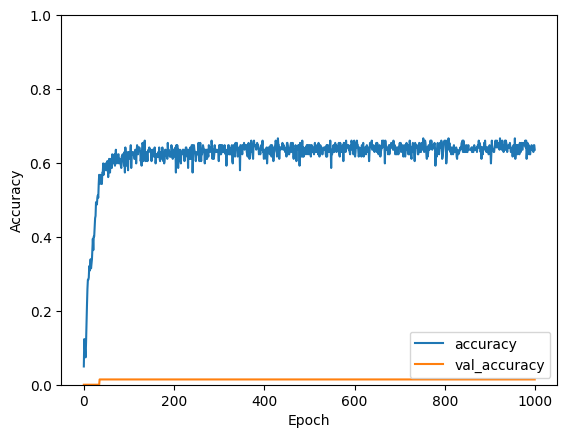

In [32]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## Export

In [33]:
# Save the entire model to a .pkl file using pickle
with open(PATH_MODEL, 'wb') as f:
    pickle.dump(model, f)

In [34]:
# # Save model and metadata
# model.save(PATH_MODEL)
# metadata = {
#     'input_size': input_size,
#     'output_size': output_size,
#     'hidden_size': hidden_size,
#     'all_words': all_words,
#     'tags': tags,
#     'label_encoder_classes': label_encoder.classes_.tolist()
# }

# with open(PATH_METADATA, 'w') as f:
#     json.dump(metadata, f)
# print('Training complete. Model and metadata saved.')

In [37]:
# Save model and metadata
# model.save(PATH_MODEL)
metadata = {
    'input_size': input_size,
    'output_size': output_size,
    'hidden_size': hidden_size,
    'all_words': all_words,
    'tags': tags,
    'vectorizer_vocabulary': vectorizer.vocabulary_,
    'label_encoder_classes': label_encoder.classes_.tolist()
}

with open(PATH_METADATA, 'w') as f:
    json.dump(metadata, f)
print('Training complete. Model and metadata saved.')

Training complete. Model and metadata saved.


In [36]:

import joblib

# Save the vectorizer
# joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(vectorizer, 'tf_vectorizer.pkl')

['vectorizer.pkl']